# Online Meta Learning : 1-D 


## We analyse the MAML algorithm for the batch mode in order to assess its convergence

## $\theta_m = \theta-\eta \nabla f_m(\theta)$

### $f_m(\theta) = -\Sigma_{n=1}^N[ y_{mn} ln\hat{y_{\theta}} + (1-y_{mn})ln(1-\hat{y_{\theta}})]\frac{1}{N}$

### Loss = - $\Sigma_{m=1}^M \Sigma_{n=1}^N[ y_{mn} ln\hat{y_{\theta_mn}} + (1-y_{mn})ln(1-\hat{y_{\theta_mn}})]\frac{1}{NM}$


## Hence we have:

## $ \frac{d\theta_i}{d\theta} = \frac{d(\theta+\frac{\eta_1}{N}(\Sigma_{x,y \sim T_i}\frac{y}{y_\theta}-\frac{1-y}{1-y_\theta})\frac{dy_\theta}{d\theta})}{d\theta} = 1-\frac{\eta_1}{N}\Sigma_{x,y \sim T_i}((\frac{y}{y_\theta^2}+\frac{1-y}{(1-y_\theta)^2})(\frac{d y_\theta}{d \theta})^2-(\frac{y}{y_\theta}-\frac{1-y}{1-y_\theta})\frac{d^2y_\theta}{d\theta^2})$

## For this setting we have  :

## $ \frac{d\theta_i}{d\theta} = \frac{d(\theta+\frac{\eta_1}{N}(\Sigma_{x,y \sim T_i}\frac{y}{y_\theta}-\frac{1-y}{1-y_\theta})\frac{dy_\theta}{d\theta})}{d\theta} = \frac{d(\theta+\frac{\eta_1}{N}(\Sigma_{x,y \sim T_i}(y(1-y_\theta)-(1-y)y_\theta))])}{d\theta} = 1-\eta_1\frac{\Sigma_{x,y \sim T_i} y_{\theta} (1-y_\theta)}{N}$

## $ \frac{d(\theta+\eta_1[1/N(\Sigma_{x,y \sim T_i}(y(1-y_\theta)-(1-y)y_\theta))])}{d\theta}$

# $\frac{d Loss}{d\theta} =  \frac{d Loss}{d y_{\theta_m}}*\frac{d y_{\theta_m}}{d\theta_m}*\frac{d\theta_m}{d\theta}$

## $=(\frac{y}{y_{\theta_m}}-\frac{1-y}{1-y_{\theta_m}})\frac{dy_{\theta_m}}{d\theta_m}*\frac{d\theta_m}{d\theta}$

## For this setting it is:

## $ = (y_{\theta_m}-y)* (1-\eta_1\frac{\Sigma_{x,y \sim T_i} y_{\theta} (1-y_\theta)}{N})$

## Hence:

## $\frac{d Loss}{d\theta} = - \frac{1}{M}\Sigma_{m=1}^M \frac{1}{N_{T_m} }\Sigma_{x,y \sim T_m} [(1-\eta_1 \Sigma_{x,y \sim T_{m_{tune}}} \frac{y_\theta (1-y_\theta)}{N})(y-y_{\theta_m})]$

## Update : $\theta \rightarrow \theta+\eta_2 \frac{1}{M}\Sigma_{m=1}^M \frac{1}{N_{T_m} }\Sigma_{x,y \sim T_m} [(1-\eta_1 \Sigma_{x,y \sim T_{m_{tune}}} \frac{y_\theta (1-y_\theta)}{N})(y-y_{\theta_{mn}})]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial import ConvexHull
from quadprog import solve_qp

def proj2hull(z, equations):
    """
    Project `z` to the convex hull defined by the
    hyperplane equations of the facets

    Arguments
        z: array, shape (ndim,)
        equations: array shape (nfacets, ndim + 1)

    Returns
        x: array, shape (ndim,)
    """
    G = np.eye(len(z), dtype=float)
    a = np.array(z, dtype=float)
    C = np.array(-equations[:, :-1], dtype=float)
    b = np.array(equations[:, -1], dtype=float)
    x, f, xu, itr, lag, act = solve_qp(G, a, C.T, b, meq=0, factorized=True)
    return x

def random_walk():
    a = np.random.randint(0,2, size = (25))
    a = np.cumsum(2*a-1)
    return(a)



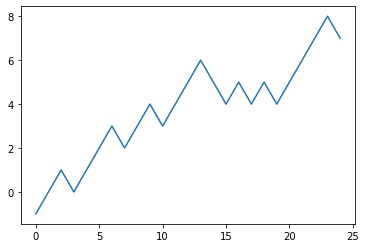

In [2]:
mean_a = random_walk()
plt.plot(-mean_a)

In [3]:
X = []
btl_loss = []
btl_param = []
X_tune = []


for (i,mean) in enumerate(mean_a):
    x_curr = np.random.randn(1000)
    x_curr = x_curr + mean
    X.append(x_curr)    
    loss_grad_btl = 0

    theta_btl = 0


In [4]:
step_size = 0.5
theta_btl = 0
step_size_fine = step_size*2

for j in range(200):

#         loss_grad_ftl = 0
    loss_grad_btl = 0
    for k,x in enumerate(X):
        # I) 1-step fine tuning for task k

        # a) Tune data points, x_tune of task m  
        if j==0:
            X_tune.append(np.random.randn(100)+mean_a[k])

        x_tune = X_tune[k]

        ind_tune_1 = x_tune > mean_a[k]
        ind_tune_0 = x_tune < mean_a[k]

        # b) Gradient of loss of task m at theta
        loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_btl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_btl)))))
        loss_fine_grad/=len(x_tune)

        # c) Fine tune update
        theta_btl_fine = theta_btl-step_size_fine*(loss_fine_grad)

        # II) Meta update on the parameter
        # a)Theta and Theta_fine predictions on x

        y_fine = 1/(1+np.exp(-(x+theta_btl_fine)))
        y_theta  = 1/(1+np.exp(-(x_tune+theta_btl)))

        # b) True labels for x 
        ind_1 = x > mean_a[k]
        y = np.array(ind_1 ,dtype = 'float')
        # c) META UPDATE
        loss_grad_btl += -1/(len(X))*(1/len(x))*(1-step_size_fine*np.sum(y_theta*(1-y_theta))/len(x_tune))*np.sum(y-y_fine)
    btl_loss.append(loss_grad_btl)
    theta_btl = theta_btl - step_size*(loss_grad_btl)
    btl_param.append(theta_btl)

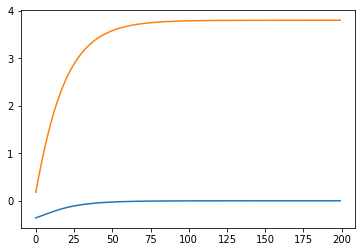

In [5]:
plt.plot(btl_loss)
plt.plot(btl_param)

Mini Max Optimisation

In [6]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


In [11]:
step_size = 0.5
theta_btl = 0
step_size_fine = step_size*2
btl_loss = []
btl_param = []
X_tune = []
X = []
p = np.ones(len(mean_a))/len(mean_a)
six = []
sixteen = []
for (i,mean) in enumerate(mean_a):
    x_curr = np.random.randn(1000)
    x_curr = x_curr + mean
    X.append(x_curr)    
    loss_grad_btl = 0

for j in range(250):

#         loss_grad_ftl = 0
    loss_grad_btl = 0
    for k,x in enumerate(X):
        # I) 1-step fine tuning for task k

        # a) Tune data points, x_tune of task m  
        if j==0:
            X_tune.append(np.random.randn(100)+mean_a[k])

        x_tune = X_tune[k]

        ind_tune_1 = x_tune > mean_a[k]
        ind_tune_0 = x_tune < mean_a[k]

        # b) Gradient of loss of task m at theta
        loss_fine_grad = (-np.sum((1-1/(1+np.exp(-(x_tune[ind_tune_1]+theta_btl)))))+np.sum(1/(1+np.exp(-(x_tune[ind_tune_0]+theta_btl)))))
        loss_fine_grad/=len(x_tune)

        # c) Fine tune update
        theta_btl_fine = theta_btl-step_size_fine*(loss_fine_grad)*p[k]

        # II) Meta update on the parameter
        # a)Theta and Theta_fine predictions on x

        y_fine = 1/(1+np.exp(-(x+theta_btl_fine)))
        y_theta  = 1/(1+np.exp(-(x_tune+theta_btl)))

        # b) True labels for x 
        ind_1 = x > mean_a[k]
        ind_0 = x < mean_a[k]
        
        y = np.array(ind_1 ,dtype = 'float')
        # c) META UPDATE
        loss_grad_btl += -p[k]*(1/len(x))*(1-step_size_fine*np.sum(y_theta*(1-y_theta))/len(x_tune))*np.sum(y-y_fine)
        
        # III) Update p
        loss_fine = (np.sum(np.log(1+np.exp(-(x[ind_1]+theta_btl_fine))))-np.sum(np.log(np.exp(-(x[ind_0]+theta_btl_fine))/(1+np.exp(-(x[ind_0]+theta_btl_fine))))))/len(x)
        p[k] += 0.1*loss_fine
        
    btl_loss.append(loss_grad_btl)
    theta_btl = theta_btl - step_size*(loss_grad_btl)
    btl_param.append(theta_btl)
    p = projection_simplex_sort(p)
    six.append(p[0])
    sixteen.append(p[23])    

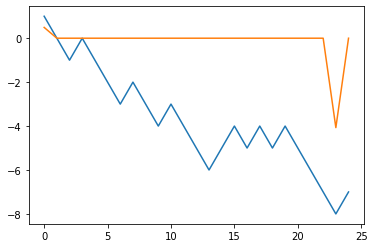

In [12]:
plt.plot(mean_a)
plt.plot(mean_a*p)

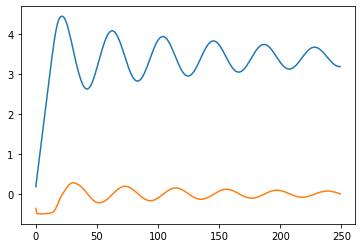

In [13]:
plt.plot(btl_param)
plt.plot(btl_loss)

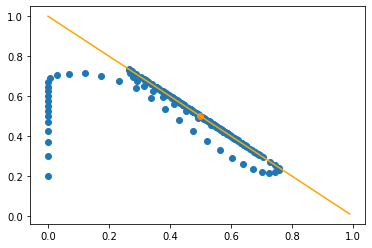

In [14]:
plt.scatter(six,sixteen)
t = np.arange(0,1,0.01)
plt.plot(t,1-t,color = 'orange')
plt.scatter(0.5,0.5)